In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob

In [3]:
fdir = '/data2/GBT/S140/'

In [4]:
fnamesA = glob.glob(fdir+'Daisy/*/*_03_*A*rfireduced.npz')
fnamesA.sort()
print len(fnamesA)

24


In [5]:
fdiode, pdiode = np.load('lownoise_calibration_3C295_03_A.npy')

In [7]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p, hits, ra_bins, dec_bins

In [127]:
calibratedA = [] 
ras = []
decs = []
gains = []
eles = []
azs = []
meansub = []
for fname in fnamesA:
    nz = np.load(fname)
    ra = nz['sra']
    dec = nz['sdec']
    ele = nz['ELEVATIO'][::8]
    az = nz['AZIMUTH'][::8]
    mask = nz['valid']
    
    gain = pdiode / ( nz['xxon'] - nz['xxoff'])
    ratio = nz['xxoff'] / nz['xxon']
    calibd = nz['xxoff'] * gain
    
    sigma = 1. / np.sqrt(1500.e6 / 512. * 0.04)
    noiseratio = ratio.std(0) / ratio.mean(0)
    bad = noiseratio > ( np.nanmedian(noiseratio) + sigma )
    mask[bad] = False
    gainmedian = np.nanmedian(np.nanmean(gain[:, mask], 1))
    gainstd = np.nanstd(np.nanmean(gain[:, mask], 1))
    tmask = np.abs(np.nanmean(gain[:, mask], 1) - gainmedian) < (4. * gainstd)
    
    calibd = calibd[tmask,:][:,mask]
    #calibd = calibd - calibd.mean(0)
    #plot(calibd.min(0))
    cleandata_tod = np.nanmean(calibd, 1)
    
    calibratedA = np.concatenate([calibratedA, cleandata_tod])
    meansub = np.concatenate([meansub, cleandata_tod - cleandata_tod.mean()])
    ras = np.concatenate([ras, ra[tmask]])
    decs = np.concatenate([decs, dec[tmask]])
    eles = np.concatenate([eles, ele[tmask]])
    azs = np.concatenate([azs, az[tmask]])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


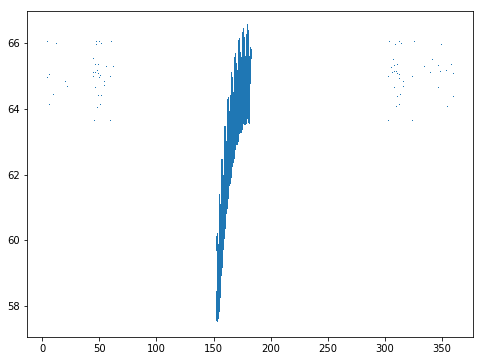

In [145]:
plot(azs % 360 , eles, ',')

In [77]:
calibd[:,30].min()

5.3438437065731241

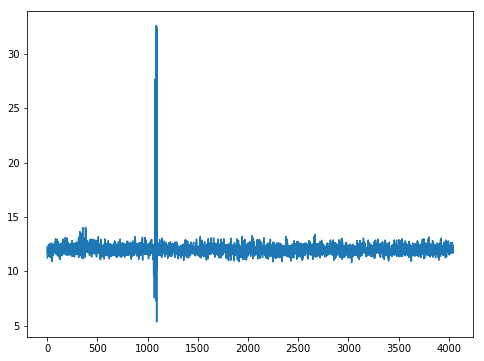

In [75]:
plot(calibd[:,30])

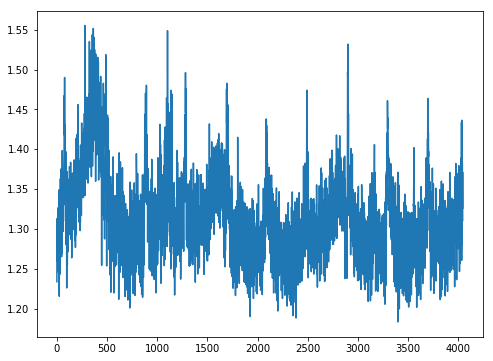

In [74]:
plot(np.nanmean(calibd - calibd.min(0), 1))

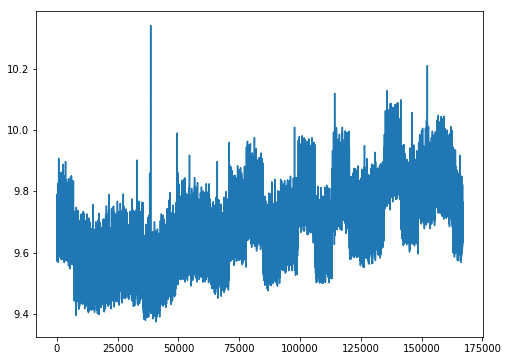

In [99]:
plot(calibratedA)

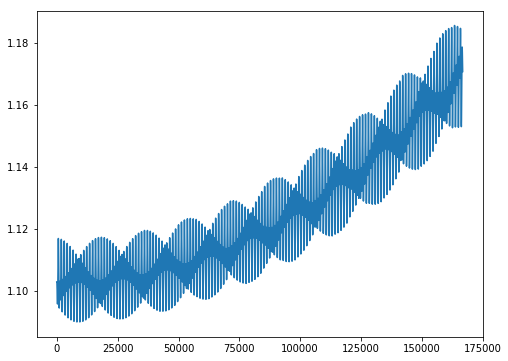

In [41]:
plot(1. / np.sin(eles * np.pi / 180.))

In [80]:
datamap, hits, rabins, decbins = naive_map(calibratedA, ras, decs, 200, 90)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


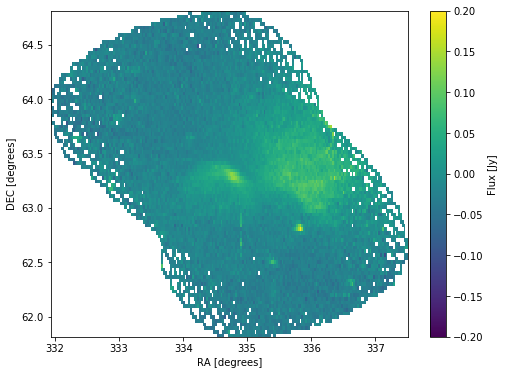

In [83]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.2, 0.2)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

In [45]:
datamap, hits, rabins, decbins = naive_map(meansub, ras, decs, 200, 90)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


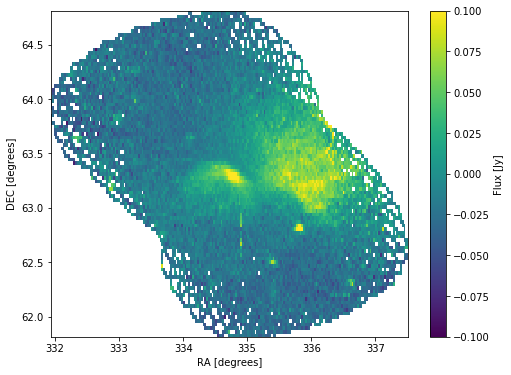

In [47]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.1, 0.1)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

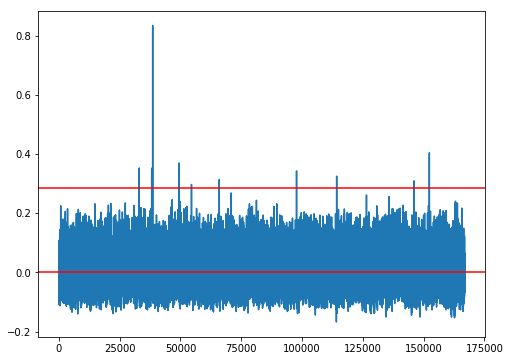

In [58]:
plot(meansub)
axhline(meansub.mean(), color='r')
axhline(meansub.mean() + 6. * meansub.std(), color='r')

In [100]:
nmask = np.abs(meansub) < (6. * meansub.std())

In [101]:
datamap, hits, rabins, decbins = naive_map(meansub[nmask], ras[nmask], decs[nmask], 200, 90)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


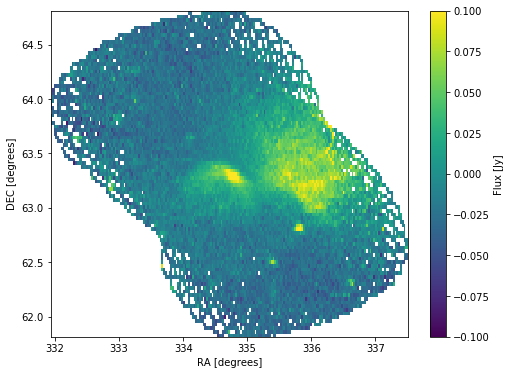

In [102]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.1, 0.1)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

In [104]:
signal.shape

(199, 89)

In [107]:
offregion = np.nanmean(signal[:,decbins[1:]>64.])

In [108]:
offregion

-0.019674895204181541

In [118]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


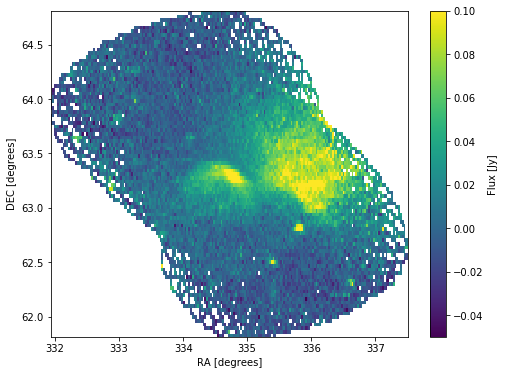

In [119]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T - offregion)
clim(-0.05, 0.1)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

In [114]:
XX, YY = meshgrid(rabins, decbins)

In [120]:
region = (XX - 334.5)**2 + (YY - 63.25)**2 < 1.

In [125]:
np.nansum(signal.T[region])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 89 but corresponding boolean dimension is 90
  if __name__ == '__main__':


-14.598140478254937

In [89]:
datamap, hits, rabins, decbins = naive_map(calibratedA, ras, decs, 350, 150)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


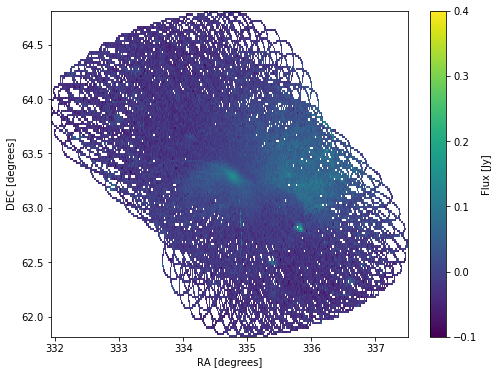

In [97]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.1, 0.4)
cb = colorbar()
#pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

In [146]:
azs %= 360

In [158]:
mask2 = (azs > 140) & (azs < 200)

In [165]:
datamap, hits, rabins, decbins = naive_map(meansub[mask2], azs[mask2], eles[mask2], 200, 90)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


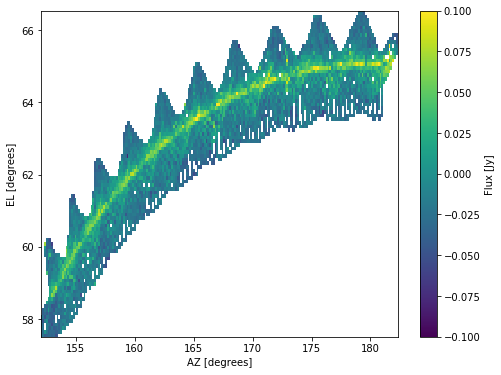

In [168]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.1, 0.1)
cb = colorbar()
#pc.cmap.set_under('w')
xlabel('AZ [degrees]')
ylabel('EL [degrees]')
cb.set_label('Flux [Jy]')

In [163]:
signal.shape

(199, 89)

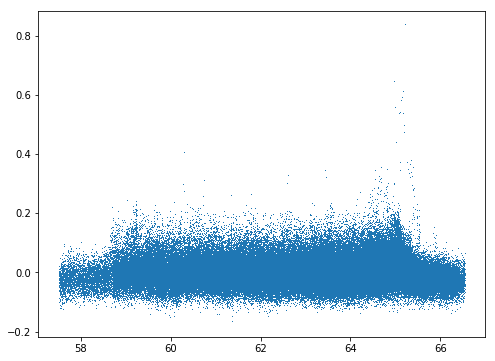

In [167]:
plot(eles[mask2], meansub[mask2], ',')

In [ ]:
plot(signal.T)